In [1]:
import os

os.environ['ARCHITECTURE'] = 'convnext'
os.environ['TILE_SIZE'] = '50'
os.environ['BATCH_SIZE'] = '50'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [2]:
from ray.tune import ResultGrid, ExperimentAnalysis, Result
from landnet.config import (
    MODELS_DIR,
    FIGURES_DIR,
    PROCESSED_DATA_DIR,
    BATCH_SIZE,
    TILE_SIZE,
)
from landnet.modelling.tune import MetricSorter
from landnet.modelling.classification.inference import InferTrainTest
from landnet.modelling.classification.stats import (
    BinaryClassificationMetricCollection,
)
from landnet.features.tiles import TileConfig, TileSize
from landnet.enums import GeomorphometricalVariable, Mode
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import geopandas as gpd
import numpy as np
import torch
from collections import defaultdict
import re
import shutil

In [3]:
TRIAL_NAME = '5cbdad8ab41a4deeba4fe764c9cc2064'
# TRIAL_NAME = 'convnext_100x100_20epochs'
METRIC = MetricSorter('val_f2_score', 'max')

In [4]:
REGEX = re.compile(r'\d+\.\d*')


def get_value_from_tensor_string(tensor_as_string: str):
    try:
        return float(REGEX.search(tensor_as_string).group(0))
    except:
        return float(tensor_as_string)


def fix_missing_predictions(
    variables: list[GeomorphometricalVariable],
    best_checkpoint_path: Path,
):
    infer = InferTrainTest(
        variables=variables, out_dir=best_checkpoint_path.parent / 'predictions'
    )
    tune_space = {
        'batch_size': BATCH_SIZE,
        'tile_config': TileConfig(TileSize(TILE_SIZE, TILE_SIZE), overlap=0),
    }
    infer.handle_checkpoint(
        best_checkpoint_path,
        tune_space,
        modes=(Mode.TRAIN, Mode.TEST, Mode.VALIDATION),
    )


def get_results_from_checkpoint_dir(checkpoint_dir: Path):
    predictions = checkpoint_dir / 'predictions'

    all_metrics = {}
    map_ = {Mode.VALIDATION: 'val'}
    for mode in (Mode.TRAIN, Mode.TEST, Mode.VALIDATION):
        metrics = pd.read_csv(
            predictions / mode.value / 'metrics.csv', index_col=0
        )
        metrics = (
            metrics.map(get_value_from_tensor_string).astype(float).iloc[:, 0]
        )
        metrics.index = map_.get(mode, mode.value) + '_' + metrics.index
        all_metrics.update(metrics.to_dict())
    return all_metrics


def parse_variables_from_config(config_path: Path):
    with open(config_path, 'r') as f:
        config = f.read().splitlines()
    variables = []
    for var in config:
        parsed = var.split('.')[1]
        variables.append(GeomorphometricalVariable._member_map_[parsed])
    return variables

In [8]:
experiments = []
experiments_dir = MODELS_DIR / TRIAL_NAME
result_paths = []
# lrs = (
#     3.146057909839248e-05,
#     2.5349719516414e-05,
#     4.022688640044346e-06,
#     5.822477020628017e-06,
#     1.4604695734325494e-05,
# )
# for learning_rate in lrs:
learning_rate = 3.146057909839248e-05
for experiment_dir in experiments_dir.iterdir():
    if not experiment_dir.is_dir():
        continue
    dirs = [file for file in experiment_dir.iterdir() if file.is_dir()]
    if len(dirs) > 1:
        raise Exception
    results: list[Result] = []
    for file in dirs[0].iterdir():
        if not file.is_dir():
            continue
        results.append(Result.from_path(file))
    if any(result.error is not None for result in results):
        raise Exception('Found errored trial')
    experiment = ExperimentAnalysis(
        dirs[0], default_metric=METRIC.metric, default_mode=METRIC.mode
    )
    # print(experiment.get)
    result = ResultGrid(experiment).get_best_result(
        metric=METRIC.metric, mode=METRIC.mode, scope='all'
    )
    result_config = result.config.copy()
    result_config['variable'] = dirs[0].parent.stem
    result_path = Path(result.path)
    result_paths.append(result_path)
    checkpoint_path = Path(
        result.get_best_checkpoint(metric=METRIC.metric, mode=METRIC.mode).path
    )
    variables = parse_variables_from_config(
        Path(experiment.experiment_path) / 'geomorphometrical_variables'
    )
    if (result_path / f'{METRIC.metric}_{METRIC.mode}_predictions').exists():
        shutil.move(
            result_path / f'{METRIC.metric}_{METRIC.mode}_predictions',
            checkpoint_path / 'predictions',
        )
    if not (checkpoint_path / 'predictions').exists():
        print('computing for', result_path)
        assert checkpoint_path
        fix_missing_predictions(
            variables,
            checkpoint_path / 'checkpoint.ckpt',
        )
        print('computed for', result_path, 'checkpoint', checkpoint_path)
    result_config.update(get_results_from_checkpoint_dir(checkpoint_path))
    result_config.update(result_config['train_loop_config'])
    result_config['checkpoint'] = checkpoint_path.name
    experiments.append(result_config)
experiments = pd.DataFrame(experiments)
experiments.to_csv(experiments_dir / 'results.csv')

In [9]:
type_ = 'test'
df_sorted = experiments[
    [
        'variable',
        'checkpoint',
        f'{type_}_f2_score',
        'val_f2_score',
        'train_loop_config',
    ]
].sort_values(f'{type_}_f2_score', ascending=False)
# df_sorted[~df_sorted['variable'].str.contains('_variables')][:60]
df_sorted[:60]

,variable,checkpoint,test_f2_score,val_f2_score,train_loop_config
14,22_variables,checkpoint_000005,0.929112,0.928127,"{'learning_rate': 2.5349719516414e-05, 'batch_..."
18,25_variables,checkpoint_000009,0.926501,0.920159,"{'learning_rate': 5.822477020628017e-06, 'batc..."
24,30_variables,checkpoint_000004,0.925536,0.932591,"{'learning_rate': 3.146057909839248e-05, 'batc..."
13,21_variables,checkpoint_000009,0.923708,0.923791,"{'learning_rate': 3.146057909839248e-05, 'batc..."
19,26_variables,checkpoint_000006,0.923455,0.924225,"{'learning_rate': 3.146057909839248e-05, 'batc..."
10,18_variables,checkpoint_000007,0.922702,0.933314,"{'learning_rate': 2.5349719516414e-05, 'batch_..."
21,28_variables,checkpoint_000005,0.922516,0.928837,"{'learning_rate': 3.146057909839248e-05, 'batc..."
6,14_variables,checkpoint_000009,0.919259,0.932591,"{'learning_rate': 3.146057909839248e-05, 'batc..."
54,9_variables,checkpoint_000007,0.918728,0.929267,"{'learning_rate': 2.5349719516414e-05, 'batch_..."
52,7_variables,checkpoint_000009,0.918685,0.925769,"{'learning_rate': 3.146057909839248e-05, 'batc..."


/tmp/ipykernel_15731/3352315557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['experiment'] = (


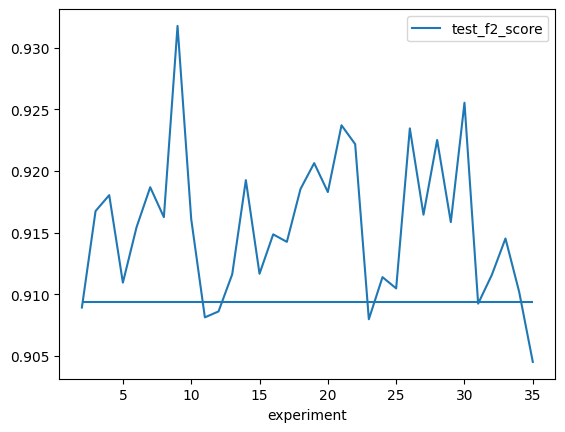

In [7]:
subset = df_sorted.loc[df_sorted['variable'].str.fullmatch(r'\d+_variables')]
subset['experiment'] = (
    subset['variable'].str.replace('_variables', '').astype(int)
)
subset.sort_values(by='experiment').plot(
    x='experiment', y='test_f2_score', kind='line'
)
plt.hlines(0.909405, 2, 35)

In [ ]:
long_df = (
    experiments.melt(
        id_vars='variable',
        value_vars=['val_f2_score'],
        var_name='metric',
        value_name='value',
    )
    .sort_values('value', ascending=False)
    .reset_index(drop=True)
)
print(long_df)
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(
    long_df,
    x='value',
    y='variable',
    hue='metric',
    orient='y',
    ax=ax,
)
ax.set_xlim(0.5, 1)

plt.tight_layout()
# plt.savefig(metrics.parent / 'metrics.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
experiments = experiments.sort_values(
    ['val_f2_score', 'train_f2_score'], ascending=False
)
sns.barplot(
    experiments,
    x='val_f2_score',
    y='variable',
    orient='y',
    ax=ax,
)
ax.set_xlim(0.7, 1)
ax.set_xlabel('Scorul F2 pentru zona de validare')
ax.set_ylabel('Variabilă geomorfometrică')
# Label with specially formatted floats
y_pos = np.arange(experiments['variable'].shape[0])

hbars = ax.barh(
    y_pos,
    experiments['val_f2_score'].values.flatten(),
    align='center',
)


ax.bar_label(hbars, fmt='%.3f')

plt.tight_layout()
plt.savefig(FIGURES_DIR.parent / 'val_f2_score.png', dpi=300)


# Scores all areas, not just split by train, test, validation

In [ ]:
def handle_tiles_directory(directory: Path):
    tiles = gpd.read_file(directory / 'tiles.fgb', inplace=True)
    logits = tiles['logits']
    y = tiles['y']
    return (torch.from_numpy(logits.values), torch.from_numpy(y.values))


def compute_metrics(logits, target):
    metrics = BinaryClassificationMetricCollection()
    metrics.update(logits, target)
    computed = metrics.compute()
    for k, v in computed.items():
        if isinstance(v, torch.Tensor):
            computed[k] = v.item()
    return computed


def handle_directory(directory: Path, mode=None):
    logits = torch.Tensor()
    targets = torch.Tensor()
    for m in (Mode.TRAIN, Mode.TEST, Mode.VALIDATION):
        if mode is not None:
            if m is not mode:
                continue
        vals = handle_tiles_directory(directory / 'predictions' / m.value)
        logits = torch.concatenate([logits, vals[0]])
        targets = torch.concatenate([targets, vals[1]])

    metrics = compute_metrics(logits, targets)
    name = directory.parent.parent.stem
    metrics['name'] = name
    metrics['path'] = directory
    return metrics


# convnext_100x100_single = [
#     file
#     for file in Path(
#         '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100'
#     ).iterdir()
#     if file.is_dir()
# ]
convnext_100x100_multidimension = [
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_10vars/convnext_100x100_10vars/TorchTrainer_cf20a57d_5_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-28_00-30-26'
    ),
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_5vars_nosecheduler_0overlap/convnext_100x100_5vars_nosecheduler_0overlap/TorchTrainer_cf20a57d_5_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-28_00-30-26'
    ),
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_5vars/convnext_100x100_5vars/2025-06-27_16-46-08/TorchTrainer_05f6ed3b_2_batch_size=2,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-27_17-10-49'
    ),
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_allvars/convnext_100x100_allvars/2025-06-30_05-31-04/TorchTrainer_1ba651e8_5_batch_size=2,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-30_03-56-18'
    ),
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/alexnet_100x100_10vars/alexnet_100x100_10vars/2025-07-01_15-34-10/TorchTrainer_dfea0359_4_batch_size=4,learning_rate=0.0001,tile_config=ref_ph_c793cfd2_2025-07-01_16-29-21'
    ),
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/resnet50_100x100_10vars/resnet50_100x100_10vars/2025-07-01_11-59-08/TorchTrainer_0e235750_2_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-07-01_11-54-45'
    ),
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_10varsNEW/convnext_100x100_10varsNEW/2025-07-02_00-27-26/TorchTrainer_07e1cffc_4_batch_size=8,learning_rate=0.0001,tile_config=ref_ph_c793cfd2_2025-07-02_00-40-54'
    ),
]

results = []
for dir in itertools.chain(best_result_paths, convnext_100x100_multidimension):
    result = handle_directory(dir)
    results.append(result)
results_df = pd.DataFrame(results)
results_df.set_index('name', inplace=True)
results_train = []
for dir in itertools.chain(best_result_paths, convnext_100x100_multidimension):
    result = handle_directory(dir, Mode.TRAIN)
    results_train.append(result)
results_train = pd.DataFrame(results_train)
results_train.set_index('name', inplace=True)
results_test = []
for dir in itertools.chain(best_result_paths, convnext_100x100_multidimension):
    result = handle_directory(dir, Mode.TEST)
    results_test.append(result)
results_test = pd.DataFrame(results_test)
results_test.set_index('name', inplace=True)
results_validation = []
for dir in itertools.chain(best_result_paths, convnext_100x100_multidimension):
    result = handle_directory(dir, Mode.VALIDATION)
    results_validation.append(result)
results_validation = pd.DataFrame(results_validation)
results_validation.set_index('name', inplace=True)

In [ ]:
if 'f2_score_train' not in results_test.columns:
    results_test = results_test.merge(
        results_train,
        left_index=True,
        right_index=True,
        suffixes=(None, '_train'),
    )
results_test = results_test.sort_values(
    by=['f2_score', 'f2_score_train'],
    ascending=False,
)
results_test.to_csv(
    PROCESSED_DATA_DIR / f'{TRIAL_NAME}_results_for_test_areas.csv'
)

In [ ]:
results_train = results_train.sort_values(
    by=['f2_score', 'sensitivity'],
    ascending=False,
)
results_train.to_csv(
    PROCESSED_DATA_DIR / f'{TRIAL_NAME}_results_for_train_areas.csv'
)

In [ ]:
results_validation = results_validation.sort_values(
    by=['f2_score', 'sensitivity'],
    ascending=False,
)
results_validation.to_csv(
    PROCESSED_DATA_DIR / f'{TRIAL_NAME}_results_for_validation_areas.csv'
)

In [ ]:
if 'f2_score_test' not in results_df.columns:
    results_df = results_df.merge(
        results_train,
        left_index=True,
        right_index=True,
        suffixes=(None, '_test'),
    )
results_df = results_df.sort_values(
    by=['f2_score', 'f2_score_test'],
    ascending=False,
)
results_df.to_csv(
    PROCESSED_DATA_DIR / f'{TRIAL_NAME}_results_for_all_areas.csv'
)